# Project 1: EDA: King County House Pricing Data Set
## Final Project Submission

Please fill out:
* Student name: Bendix Haß


## Business Understanding

### Fictional business case: Prefabricator analyzing market segment in and around Seattle

The fictional case is that We am an analyst at a large housing prefabricator. We want to predict possible market values for our housetypes Athens and Berlin. We will map the local housing market onto our portfolio and derive business decisions for a possible expansion strategy to King County.

## Setup

Core setup for the Notebook. You will find all imported packages etc. here.

In [1]:
reset -fs

In [2]:
# If folium is not installed yet, run following line:
# conda install -c conda-forge folium -y

In [3]:
import numpy as np
import pandas as pd
import datetime

from scipy import stats
import scipy.optimize as opt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
import folium as folium
import branca.colormap as cm

In [4]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import check_array
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

### Building Condition

An indicator for building condition in the dataset is defined as follows:

[Source](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

Relative to age and grade. Coded 1-5.

    1 = Poor- Worn out.
    2 = Fair- Badly worn.
    3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing.
    4 = Good- No obvious maintenance required.
    5= Very Good- All items well maintained.

### Building Grade

An indicator for building grade in the dataset is defined as follows:

[Source](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

    1-3 Falls short of minimum building standards. Normally cabin or inferior structure.
    4 Generally older, low quality construction. Does not meet code.
    5 Low construction costs and workmanship. Small, simple design.
    6 Lowest grade currently meeting building code. Low quality materials and simple designs.
    7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.
    8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
    9 Better architectural design with extra interior and exterior design and quality.
    10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
    11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
    12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
    13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

## Data Mining

Gather and scrape the data necessary for the project

### Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **date** - Date house was sold
* **price** - Price: is prediction target
* **bedrooms** - Number of Bedrooms/House
* **bathrooms** - Number of Bathrooms/House
* **sqft_living** - square footage of the home
* **sqft_lot** - square footage of the lot
* **floors** - Total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [5]:
df = pd.read_csv('King_County_House_prices_dataset.csv', delimiter=',')
#df.info()

In [6]:
#df.head(5);

In [7]:
#df.tail(5)

## Data Cleaning

Fix the inconsistencies within the data and handle the missing values

### Handling NaN
We have missing data in the Features: **view**, **waterfront** and **yr_renovated**. Those will be dealt with.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


### Sequence data by continuous/categorical/misc

For further understanding we sort the variables by possible type

continuous = ['date', 'price', 'bedrooms', 'bathrooms'
              , 'sqft_living', 'sqft_lot', 'floors'
              , 'sqft_above', 'sqft_basement', 'yr_built'
              , 'yr_renovated', 'zipcode', 'lat', 'long'
              , 'sqft_living15', 'sqft_lot15']

categorical = ['waterfront', 'view', 'condition', 'grade']

misc = ['id']

In [9]:
df.nunique()

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

### Data types

Most of the data types are expected. Unexpected are listed below:
1. **date** should be a DateTime type
2. **price** can be integer. Decimal float point values are of no interest
3. **bathrooms** follows this calculation: [bath](https://illinado.com/what-is-a-quarter-bath/)
4. **floors** .5-values are pitched-roof stories
5. **waterfront**, **view**, **yr_renovated**, **sqft_basement** can be cast to integer

In [10]:
# We wonder why baths is a floating point variable
df.bathrooms.unique()

# conclusion: it follows a calculation of quarter baths
# bath: toilet = 0.25, toilet + sink = 0.5, toilet + sink + shower = 0.75, toilet + sink + shower + tub = 1

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 0.5 , 5.5 ,
       6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [11]:
# We wonder why floors is a floating point variable
df.floors.unique()

# conclusion: stories under a pitched roof are .5 floors

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [12]:
# We wonder why waterfront is a floating point variable
df.waterfront.unique()

# conclusion: can be casted to integer after NaNs are handled

array([nan,  0.,  1.])

In [13]:
# What is the expected value for waterfront?
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [14]:
# <1% are at a waterfront.
# We will replace nan-values by 0 (not expected to be at waterfront)
df.waterfront.replace(to_replace=[np.nan], value=0, inplace=True);

In [15]:
# We wonder why view is a floating point variable
df.view.unique()

# conclusion: view can be casted to int64 after handling NaNs

array([ 0., nan,  3.,  4.,  2.,  1.])

In [16]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [17]:
# ~10% have a view of 0.
# We will replace nan-values by 0
df.view.replace(to_replace=[np.nan], value=0, inplace=True);

In [18]:
# We wonder why yr_renovated is a floating point variable
df.yr_renovated.unique()

# conclusion: yr_renovated can be casted to int64 after handling NaNs

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [19]:
df.yr_renovated.value_counts(dropna=False)
# 79% has not been renovated
# 18% is NaN
# conclusion: NaN will be replaced by 0
df.yr_renovated.replace(to_replace=[np.nan], value=0, inplace=True);

In [20]:
# We wonder why sqft_basement is of type object
df.sqft_basement.unique();

# conclusion: sqft_basement contains '?' but could be casted to int64

In [21]:
# sqft_basement has '?' values. 
# Wet cannot be casted to int64
# Those '?' will be replaced by the mode
df.sqft_basement.replace(to_replace=['?'], value=df.sqft_basement.mode(), inplace=True);

In [22]:
# Casting Series types:
df.date = pd.to_datetime(df.date)

# casting from object -> float -> round -> int necessary
for feat in ['price', 'waterfront', 'view', 'yr_renovated', 'sqft_basement']:
    df[feat] = df[feat].astype(float).round(0).astype(int)

### Inconsistent data:
1. **ID**: some houses seem to be doubled: dataset has 21597 entries but only 21420 unique IDs
2. **bedrooms**: We seem to have 1 data point with 30+ bedrooms, We will get rid of this one

In [23]:
df.drop(inplace=True, index=df[df.bedrooms > 30].index)

### Market segment - lot area, pricing, luxury, housetypes etc.

We will now look at the market segment in housing constellation. For those decisions We will generate some plots 

The following plots will show some detailed decisions about the market segment. The results will be listed below:

1. The lot area below 20000 $ft^2$ is about 90% if the market segment
2. Houses (incl. lot) below 1 mio USD also are about 90% of the market segment
3. Houses older than 1960s are overly attractive (will be dropped)
4. Portfolio:
    1. up until 3 bathrooms recommended
    2. up until 5 bedrooms recommended
    3. up until 2 floors recommended

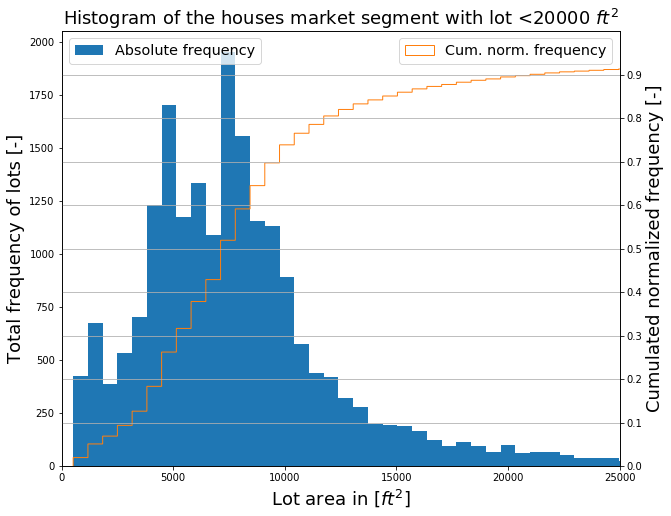

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()
bins = 2500
fontsize = 'x-large'
labelsize = 18
ticksize = 16

ax1.set(xlabel='Lot area in [$ft^2$]'
       , ylabel='Total frequency of lots [-]')

ax2.set(xlim=(0, 25e3)
        , ylim=(0, 1)
        , yticks=np.arange(0, 1, step=0.1)
        , ylabel='Cumulated normalized frequency [-]'
        , title='Histogram of the houses market segment with lot <20000 $ft^2$')
ax2.grid(True)

hst1 = ax1.hist(
    df.sqft_lot
    , bins=bins
    , density=False
    , label='Absolute frequency')

hst2 = ax2.hist(
    df.sqft_lot, cumulative=1
    , histtype='step'
    , bins=bins
    , color='tab:orange'
    , density=True
    , label='Cum. norm. frequency')

ax1.xaxis.label.set_fontsize(labelsize)
ax1.yaxis.label.set_fontsize(labelsize)
#ax1.get_xticklabels().set_fontsize(ticksize)
#ax1.get_yticklabels().set_fontsize(ticksize)
ax1.legend(loc='upper left', fontsize=fontsize)
ax2.yaxis.label.set_fontsize(labelsize)
#ax2.get_yticklabels().set_fontsize(ticksize)
ax2.legend(fontsize=fontsize)
ax2.title.set_fontsize(labelsize)

As we can see the market segment below 20k sqft represents about 90% of the local market. This is a business recommendation for further expansion

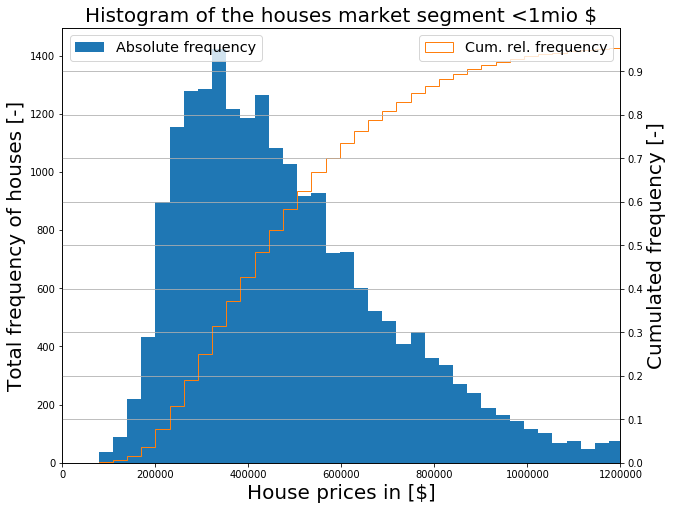

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()
bins = 250
fontsize = 'x-large'
labelsize = 20
ticksize = 16

ax1.set(xlabel='House prices in [\$]'
       , ylabel='Total frequency of houses [-]')

ax2.set(xlim=(0, 12e5)
        , ylim=(0, 1)
        , yticks=np.arange(0, 1, step=0.1)
        , ylabel='Cumulated frequency [-]'
        , title='Histogram of the houses market segment <1mio $')

ax2.grid(True)

hst1 = ax1.hist(
    df.price
    , bins=bins
    , density=False
    , label='Absolute frequency')


hst2 = ax2.hist(
    df.price
    , cumulative=1
    , histtype='step'
    , bins=bins
    , color='tab:orange'
    , density=True
    , label='Cum. rel. frequency')

ax1.xaxis.label.set_fontsize(labelsize)
ax1.yaxis.label.set_fontsize(labelsize)
#ax1.get_xticklabels().set_fontsize(ticksize)
#ax1.get_yticklabels().set_fontsize(ticksize)
ax1.legend(loc='upper left', fontsize=fontsize)
ax2.yaxis.label.set_fontsize(labelsize)
#ax2.get_yticklabels().set_fontsize(ticksize)
ax2.legend(fontsize=fontsize)
ax2.title.set_fontsize(labelsize)

The market segment below 1 mio. US$ (not yet adjusted to inflation and dearness) represents 95% of the local housing market. This is a key upper limit for the portfolio.

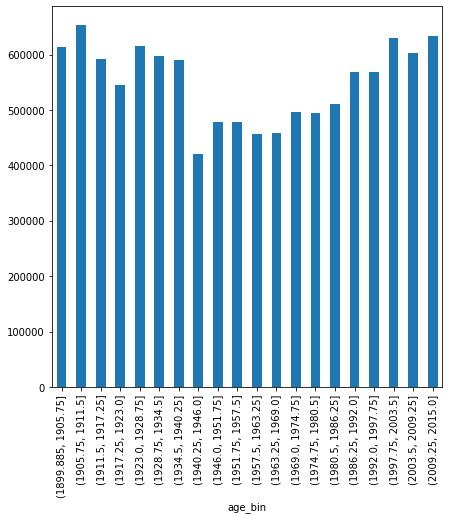

In [26]:
df_tmp = df.copy()
df_tmp['age_bin'] = pd.cut(df.yr_built, bins=20)
df_tmp.groupby(by='age_bin').price.mean().plot(kind='bar'
    , figsize=(7, 7))

Here We grouped up mean prices by age. We see a rise since ca. 1960. We will concentrate on this segment because older houses would be preferable because of their age. This wont match our portfolio.

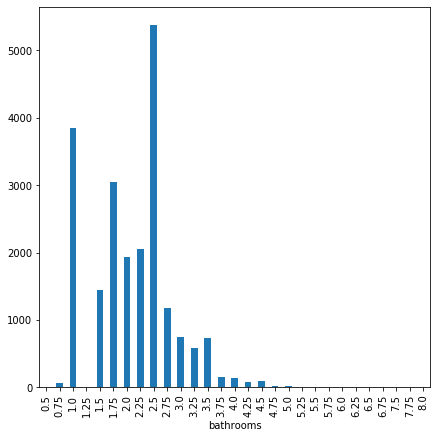

In [27]:
df_tmp.groupby(by='bathrooms').bathrooms.count().plot(kind='bar'
    , figsize=(7, 7))

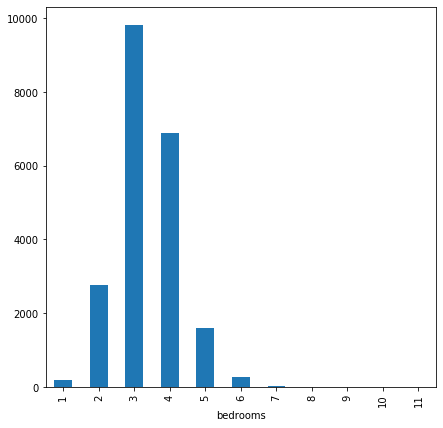

In [28]:
df_tmp.groupby(by='bedrooms').bedrooms.count().plot(kind='bar'
    , figsize=(7, 7))

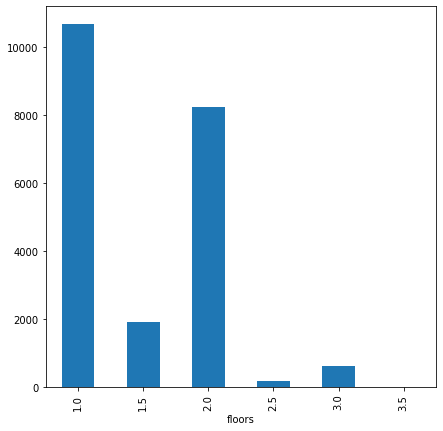

In [29]:
df_tmp.groupby(by='floors').floors.count().plot(kind='bar'
    , figsize=(7, 7))

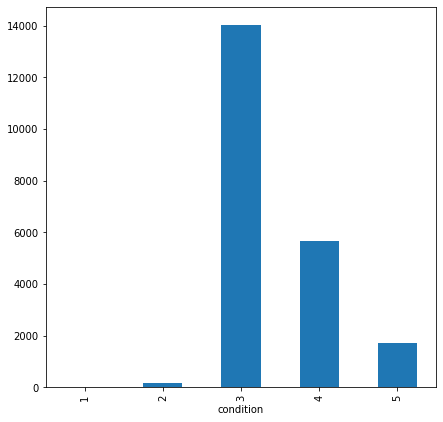

In [30]:
df_tmp.groupby(by='condition').condition.count().plot(kind='bar'
    , figsize=(7, 7))

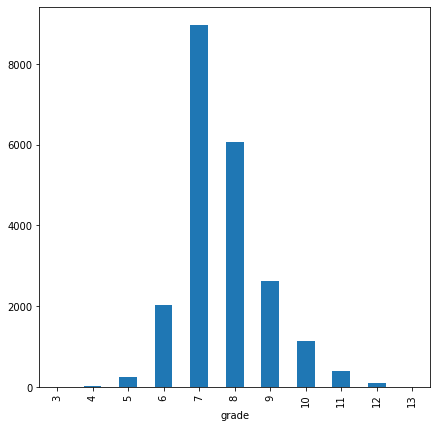

In [31]:
df_tmp.groupby(by='grade').grade.count().plot(kind='bar'
    , figsize=(7, 7))

We took a look at the distribution of the market segment. The portfolio is well represented within the market after all. We will filter out the rows outside of the portfolio to better represent the portfolio with the dataset. By looking at those graphs above, we set the filter as follows:
* bathrooms <= 2.5
* bedrooms <= 5
* floors <= 2
* condition >= 3
* grade >= 7

In [32]:
df.drop(index=df[df['bathrooms'] > 2.5].index, inplace=True, axis=0)
df.drop(index=df[df['bedrooms'] > 5].index, inplace=True, axis=0)
df.drop(index=df[df['floors'] > 2].index, inplace=True, axis=0)
df.drop(index=df[df['condition'] < 3].index, inplace=True, axis=0)
df.drop(index=df[df['grade'] < 7].index, inplace=True, axis=0)
df.shape
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
6,1321400060,2014-06-27,257500,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,2015-01-15,291850,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### Key indicators of luxury location: waterfront

As feature waterfront is too onesided and might outperform other features as attractor or impulse to buy a house. We will get rid of this feature because it is a key indicator of the lot and not the house.

1. **waterfront** other that 0 lines will be dropped because they are noted as luxury lots. Features will be dropped after.
2. **sqft_lot** above 20000 ft^2 rows will be dropped

### Unnecessary features

1. **id** implies no insight, feature will be dropped
2. **sqft_lot**, **view**, **yr_renovated**, **zipcode**, **lat**, **long**, **sqft_living15**, **sqft_lot15** are features We wont be able to define as indicators without a precise project including precise project area. But We will keep those for now for some additional analysis later.

### Filtering Dataset for Business Case
1. Applying filters from business case:
    1. sqft_lot < 20000
    2. price < 1 mio\$
    3. waterfront = 0
    4. view = 0

In [33]:
for feat in ['waterfront', 'view']:
    df.drop(inplace=True, index=df[df[feat] > 0].index)

df.drop(index=df[df['sqft_lot'] > 2e5].index, inplace=True, axis=0)
df.drop(index=df[df['price'] > 1e6].index, inplace=True, axis=0)
df.drop(columns=['waterfront', 'view', 'id'], inplace=True, axis=1);

## Data Exploration

Now that our data is clean and all datatypes are adjusted We can continue with the data exploration. We will find hypothesis about your defined problem by visually analyze the data

### Correlation Matrix - find unrelated features
First of all lets take a look at the correlation matrix

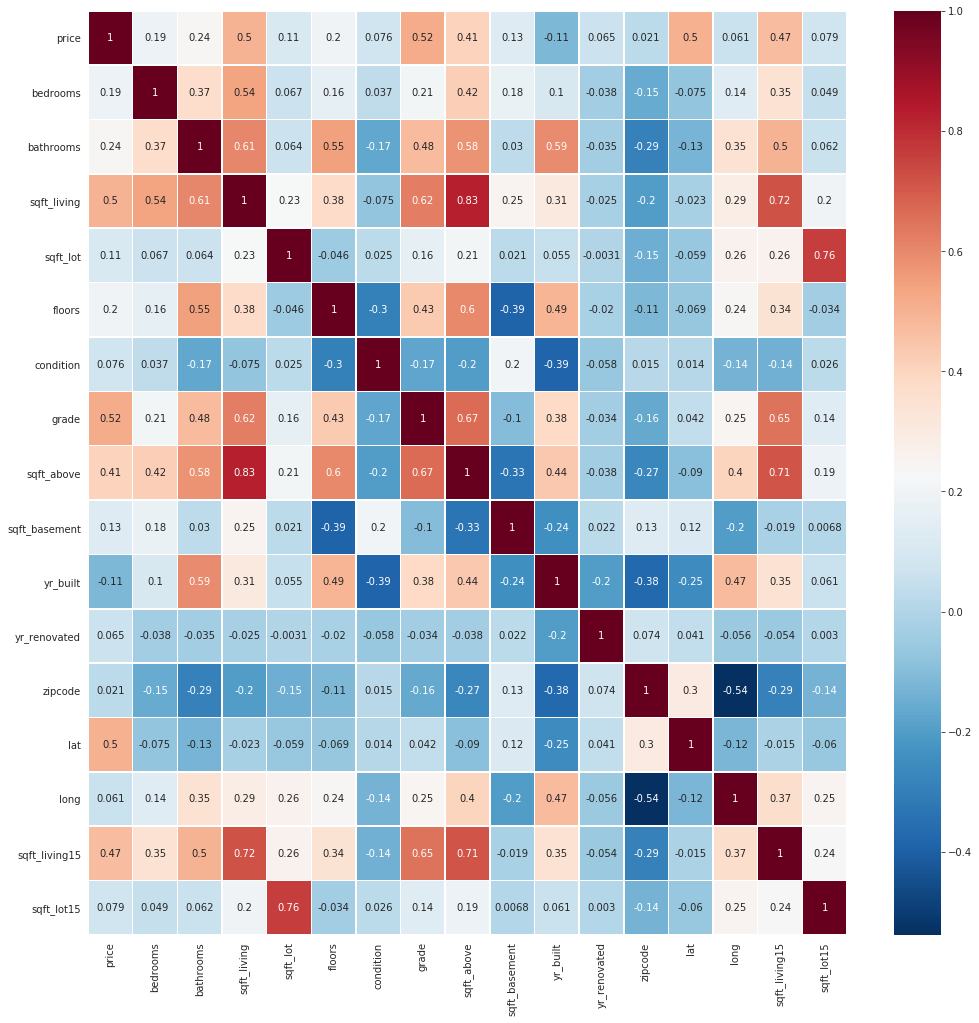

In [34]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(17, 17))
    ax = sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap="RdBu_r")

### Pairplot - How about the distributions? 
Also interesting is the pairplot. To have a slim overview We need to sort out some of the features. This is an iterative process. First of all lets sort out some seemingly uncorrelated features because We probably wont get insights of them in the pairplot.

+ sqft_lot15
+ lat
+ zipcode
+ yr_built
+ condition
+ sqft_lot
+ id
+ waterfront

The remaining will be set in 3 sets. All sets will contain the target feature **price**

In [35]:
# Filter some misc and categorical features that won't add insights to the plot
sorted_out = ['id', 'lat', 'zipcode']

no_pairplot = ['price', 'sqft_lot15', 'yr_built'
              , 'condition', 'sqft_lot']

showpairplot = [i for i in df.columns 
                if (i not in no_pairplot) and 
               (i not in sorted_out)]

sets = [showpairplot[:5]+['price'], showpairplot[4:8]+['price'], showpairplot[8:]+['price']]

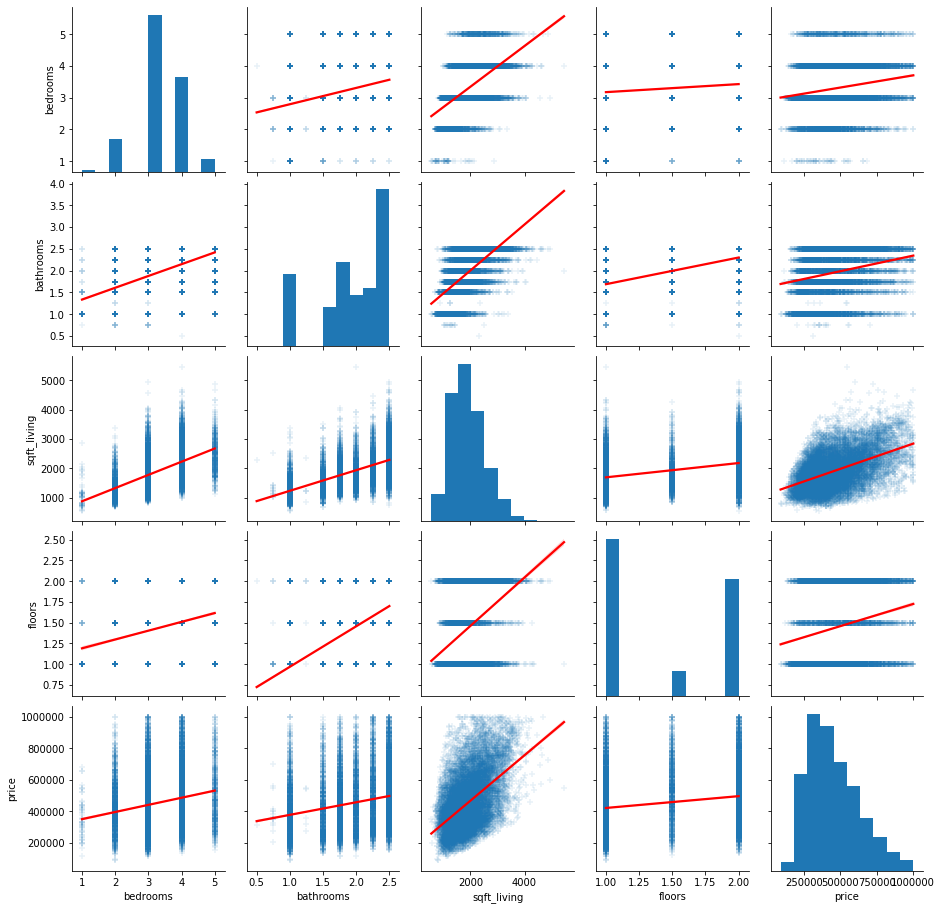

In [36]:
sns.pairplot(df[sets[0]]
             , markers="+", kind='reg'
             , plot_kws={'line_kws':{'color':'red'}
                         , 'scatter_kws': {'alpha': 0.1}}
            )

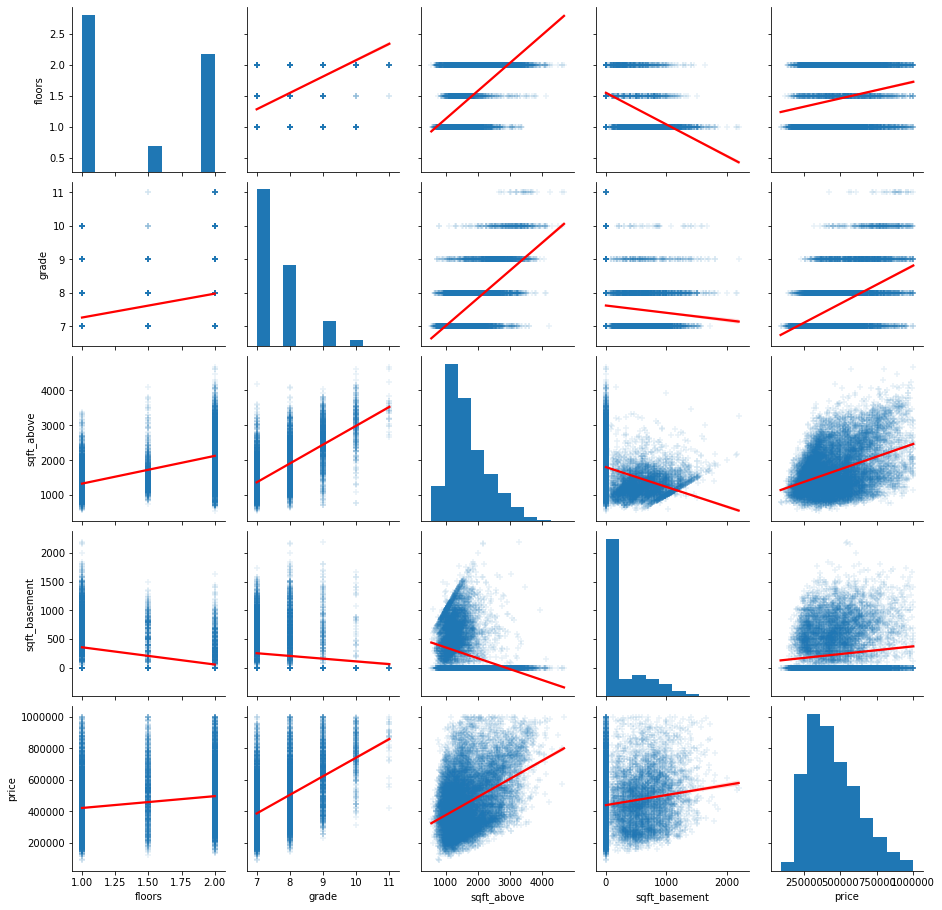

In [37]:
sns.pairplot(df[sets[1]]
             , markers="+", kind='reg'
             , plot_kws={'line_kws':{'color':'red'}
                         , 'scatter_kws': {'alpha': 0.1}}
            )

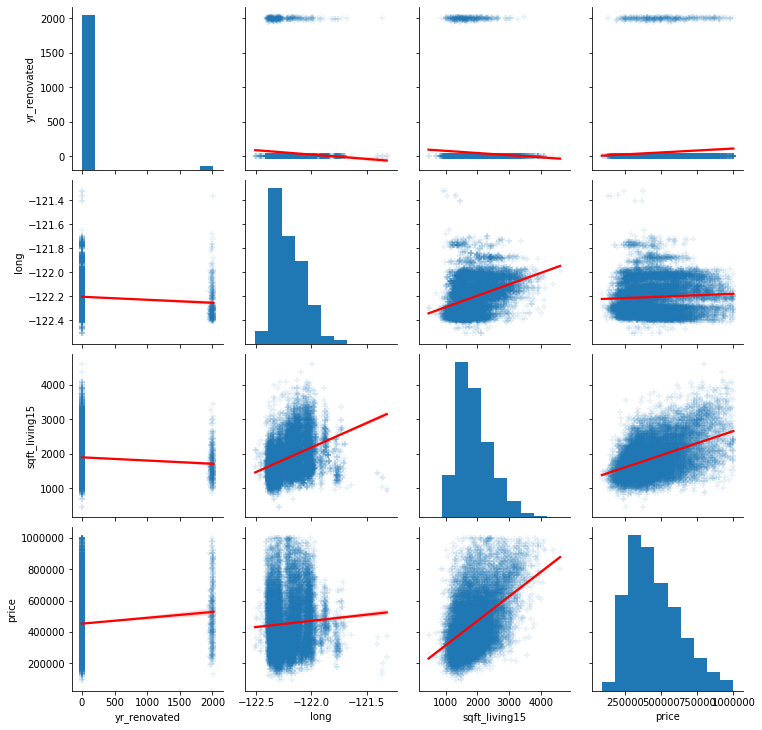

In [38]:
sns.pairplot(df[sets[2]]
             , markers="+", kind='reg'
             , plot_kws={'line_kws':{'color':'red'}
                         , 'scatter_kws': {'alpha': 0.1}}
            )

### Let's take a look at the outsorted features:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a227c8a58>,
      dtype=object)

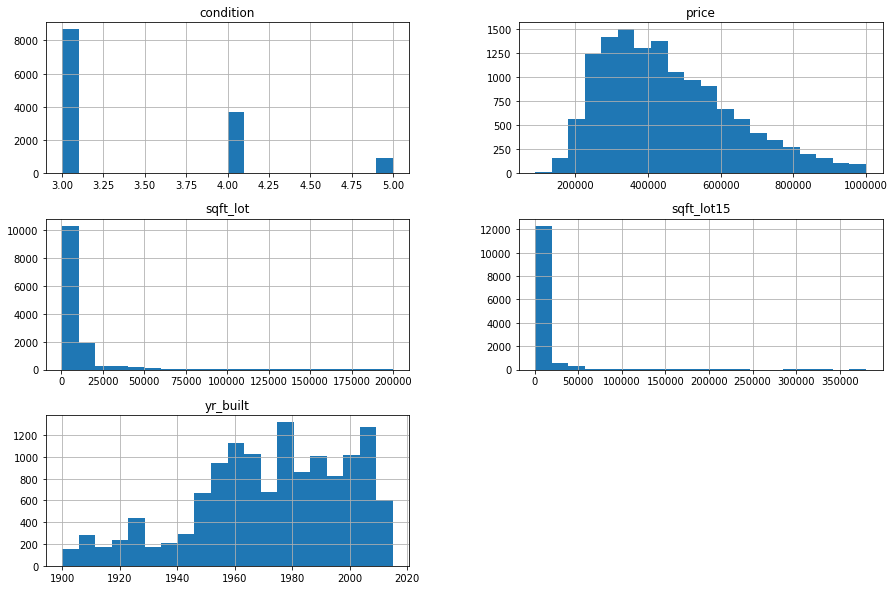

In [39]:
df[no_pairplot].hist(figsize=(15, 10), bins=20)

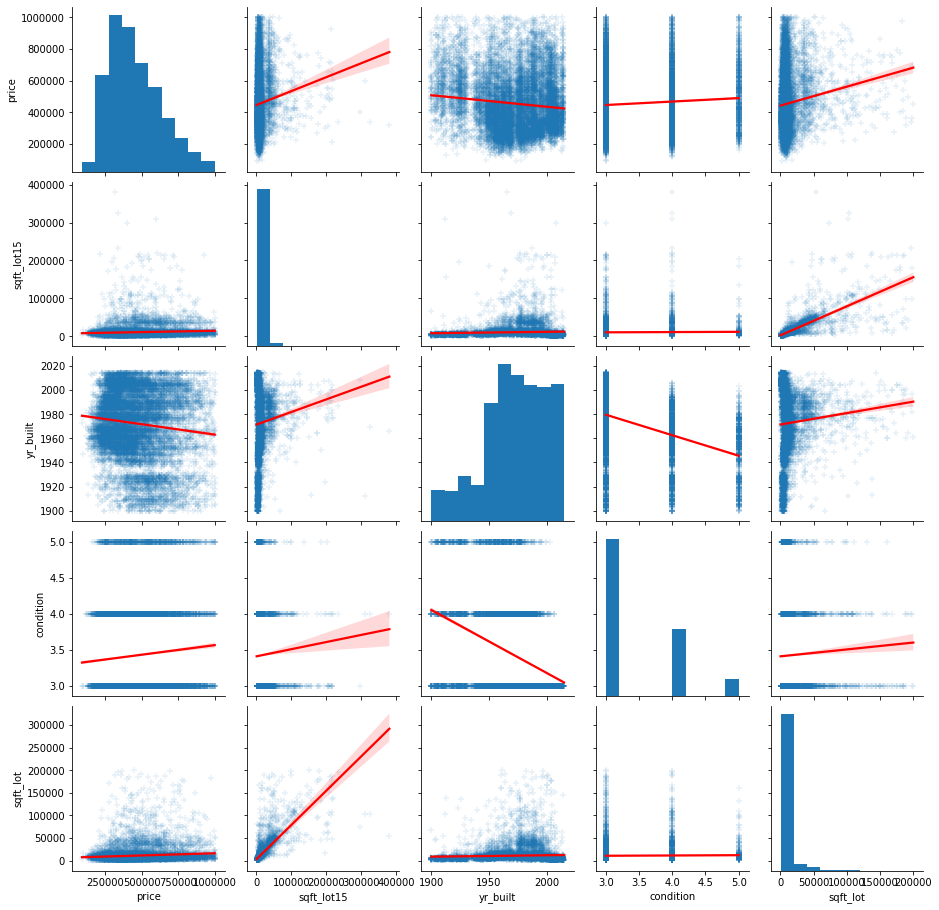

In [40]:
sns.pairplot(df[no_pairplot]
             , markers="+", kind='reg'
             , plot_kws={'line_kws':{'color':'red'}
                         , 'scatter_kws': {'alpha': 0.1}}
            )

## Feature Engineering

Select important features and construct more meaningful ones using the raw data that We have.

### Feature: inflation and housing dearness adjustment

We will adjust the prices in the dataset for the current year 2020.
This feature probably won't increase test-set prediction quality but since We need to extrapolate to the year 2020 We will increase the quality of predictions for further business decisions.

https://fred.stlouisfed.org/series/ATNHPWeUS53033A

| year | index |
| ---- | ------ |
| 2014 | 156.44 |
| 2015 | 168.53 |
| 2016 | 190.37 |
| 2017 | 215.14 |
| 2018 | 236.72 | 

In [41]:
a = [156.44, 168.53, 190.37, 215.14, 236.72]
p_inc = np.mean([(a[i+1]-a[i])/a[i] for i in range(len(a)-1)])

Which gives us a mean index increase of about 11% per year. We will extrapolate this further until 2020. The index is not inflation adjusted, so We do not need to consider inflation additionally.

In [42]:
df['price_adj'] = df.price * (p_inc + 1) ** np.float64((pd.Timestamp.now()-df.date).dt.days/365)

Reminder: As We discounted the prices over the years, We wont be using the **date** feature as an indicator anymore. We adjusted the dataset prices by the real pricing increase over the years. 

### Feature: relative Housing price $\left[\frac{\$ }{ft^2}\right]$

Typical indicator is a relative price per living area. We will create this feature with the total area of the house. Since the goal is to predict the total house price, We wont use this feature because of colinearity but as an indicator of favourable locations later.

In [43]:
df['spec_price'] = df.price/df.sqft_living

### Age

Instead of using **yr_built** and **yr_renovated** We will define a feature age, which will be the nearest of those dates.

In [44]:
df['age'] = df.yr_built.combine(df.yr_renovated, max)
df[['age', 'yr_built', 'yr_renovated']].head()

,age,yr_built,yr_renovated
0,1955,1955,0
1,1991,1951,1991
4,1987,1987,0
6,1995,1995,0
7,1963,1963,0


### Categorical Features

We will create dummy variables for categorical features. This will be zipcode

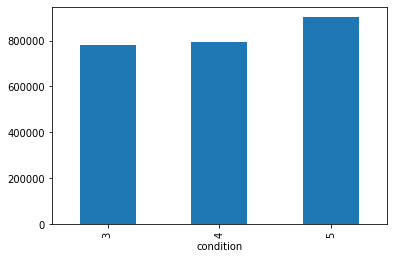

In [45]:
df.groupby(by='condition').price_adj.mean().plot(kind='bar')

_tmp = pd.get_dummies(df.condition, drop_first=True, prefix='cond_')
df = df.join(_tmp)
df.drop(labels='condition', axis=1, inplace=True)

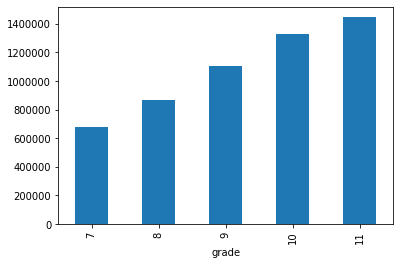

In [46]:
df.groupby(by='grade').price_adj.mean().plot(kind='bar')

_tmp = pd.get_dummies(df.grade, drop_first=True, prefix='grade_')
df = df.join(_tmp)
df.drop(labels='grade', axis=1, inplace=True)

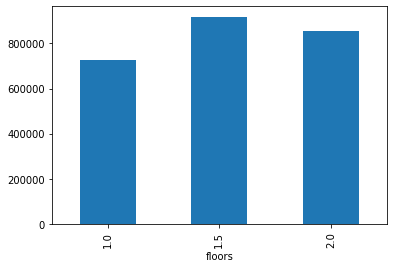

In [47]:
df.groupby(by='floors').price_adj.mean().plot(kind='bar')

In [48]:
for col in ['condition', 'floors', 'grade']:
    _tmp = pd.get_dummies(df[col], drop_first=True, prefix=col)
    df = df.join(_tmp)
    df.drop(labels=col, axis=1, inplace=True)

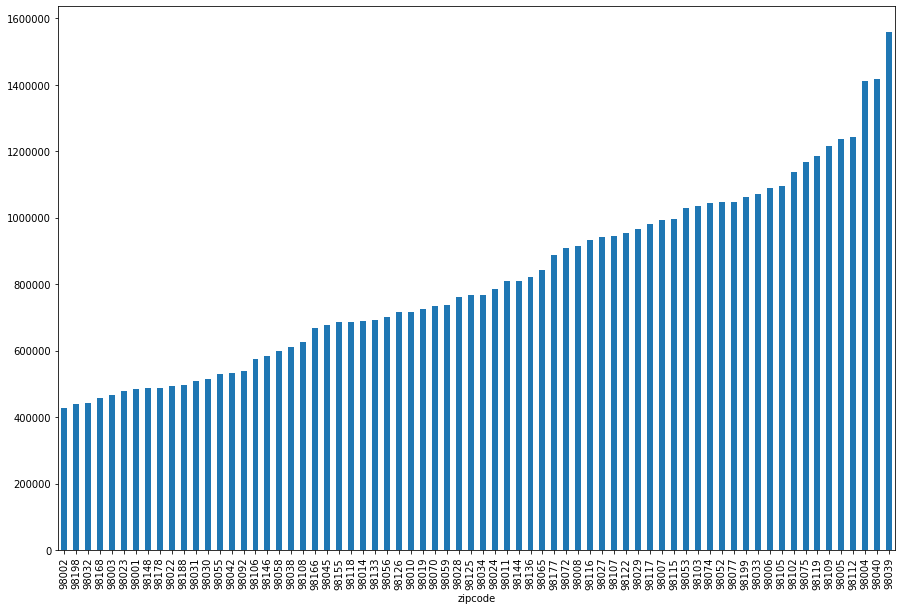

In [49]:
df.groupby(by='zipcode').price_adj.mean().sort_values().plot(kind='bar', figsize=(15, 10))

We have a beautiful pattern in the zipcodes. Wet is a shame, We cant make use of that because those zipcodes are way to unordered. But wait, We will use a dummy continuous variable.

Get the pattern and then zip it together with a continuous variable.

In [50]:
_tmp = df.groupby(by='zipcode').price_adj.mean().sort_values()
zip_sorted = dict(zip(_tmp.index, list(range(len(_tmp.index)))))

Now We will add a Series 'zip_sort' from this pattern We previously zipped together.

In [51]:
df['zip_sort'] = [zip_sorted[zipcode] for zipcode in df.zipcode]
# df.groupby('zip_sort').price_adj.mean().plot(kind='bar', figsize=(15, 10)) # run this line to check if it worked

### Overview

In [52]:
len(df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13281 entries, 0 to 21596
Data columns (total 27 columns):
date             13281 non-null datetime64[ns]
price            13281 non-null int64
bedrooms         13281 non-null int64
bathrooms        13281 non-null float64
sqft_living      13281 non-null int64
sqft_lot         13281 non-null int64
sqft_above       13281 non-null int64
sqft_basement    13281 non-null int64
yr_built         13281 non-null int64
yr_renovated     13281 non-null int64
zipcode          13281 non-null int64
lat              13281 non-null float64
long             13281 non-null float64
sqft_living15    13281 non-null int64
sqft_lot15       13281 non-null int64
price_adj        13281 non-null float64
spec_price       13281 non-null float64
age              13281 non-null int64
condition_4      13281 non-null uint8
condition_5      13281 non-null uint8
floors_1.5       13281 non-null uint8
floors_2.0       13281 non-null uint8
grade_8          13281 non-null uint

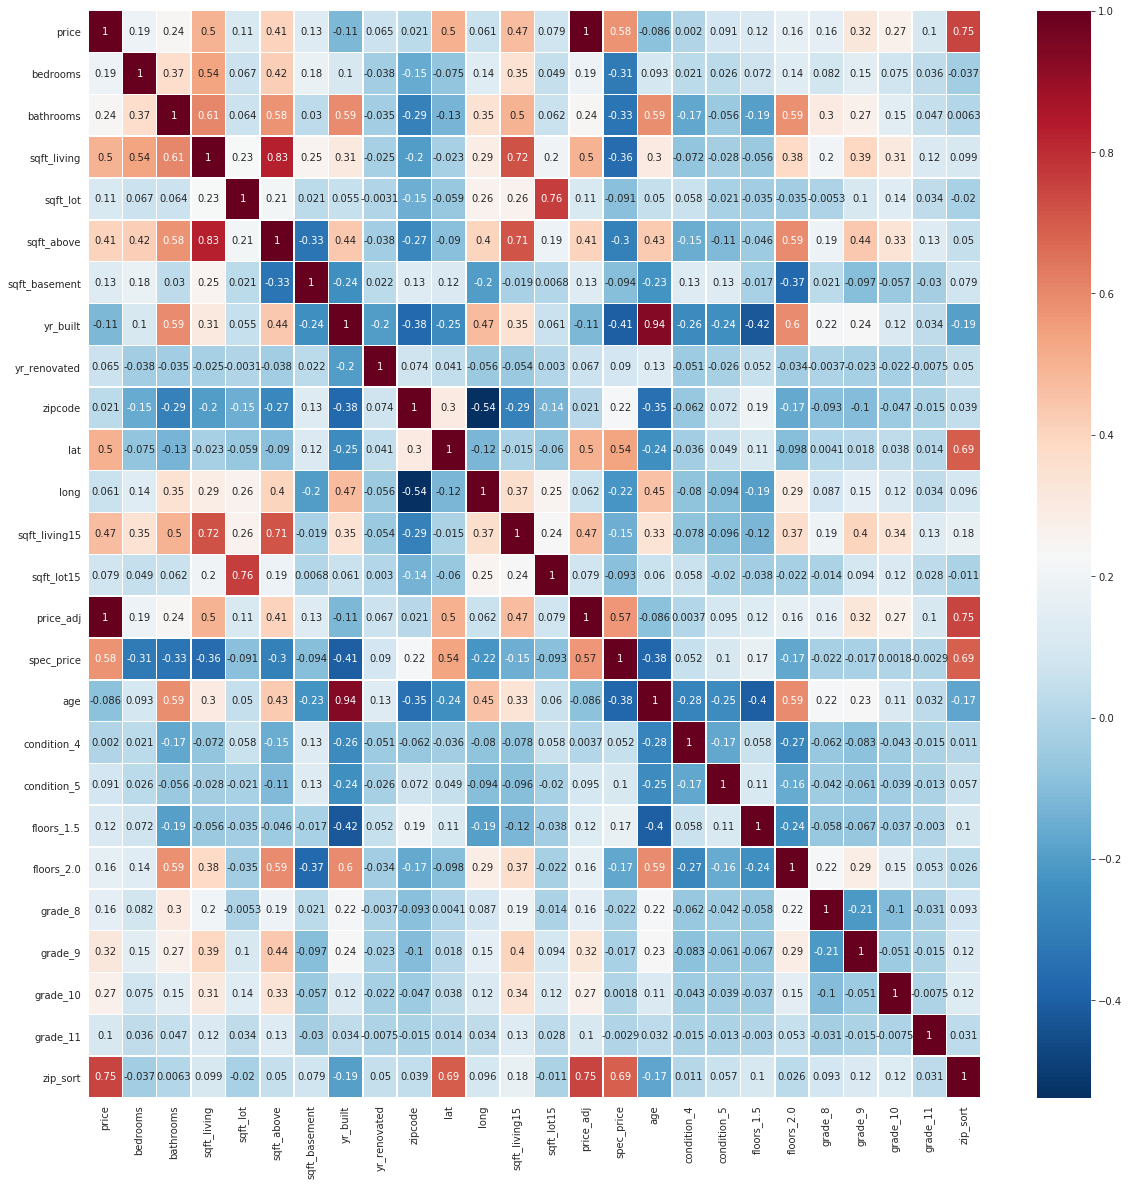

In [53]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap="RdBu_r")

## Predictive Modeling

Train machine learning models, evaluate their performance and use them to make predictions.

We will create models to predict the prefabrication portfolio for the 2 (fictional) houses Athens and Berlin. Assuming we know the 

### Small setup further predictions

We will create a short function to quickly compare models via train-test-evaluation. Look at the following.

In [54]:
# Define the evaluation metric
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.asanyarray(np.abs((y_true - y_pred) / y_true)) * 100)

In [55]:
# Define a short function whicht will train-test-split, train, test, evaluate all in one step. 
# Returns the MAPE (mean absolute percentage error)
def quick_train_eval(df, feat_x, feat_y, method='poly1', s=.2):
    X = df[feat_x]
    y = df[feat_y]
    #X = preprocessing.StandardScaler().fit(X).transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=s, random_state=1)
    
    if method == 'poly1':
        model = linear_model.LinearRegression()
    elif method == 'poly2':
        model = linear_model.LinearRegression()
        poly = PolynomialFeatures(degree=2)
        X_train = poly.fit_transform(X_train)
        X_test = poly.fit_transform(X_test)
    elif method == 'poly3':
        model = linear_model.LinearRegression()
        poly = PolynomialFeatures(degree=3)
        X_train = poly.fit_transform(X_train)
        X_test = poly.fit_transform(X_test)
        
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    
    MAPE = mean_absolute_percentage_error(y_test, y_hat)
    # calculate MAE, MSE, RMSE
    #print('MAE\t', metrics.mean_absolute_error(y_test, y_hat))
    #print('MSE\t', metrics.mean_squared_error(y_test, y_hat))
    #print('RMSE\t', np.sqrt(metrics.mean_squared_error(y_test, y_hat)))
    print('MAPE\t', MAPE)
    
    return MAPE

Let's sort the features into those We can use and those We can't or won't use. For further information look at chapter "Business Understanding" and "Data Cleaning"

In [56]:
no_predictor = ['date'
                , 'price'
                , 'spec_price'
                , 'sqft_lot'
                , 'zipcode'
                , 'lat'
                , 'long'
                , 'sqft_living15'
                , 'sqft_above'
                , 'sqft_lot15'
                , 'yr_renovated'
                , 'yr_built']

target = ['price_adj']

preds = [feat for feat in df.columns if feat not in no_predictor+target]

In [57]:
quick_train_eval(df, preds, target)

MAPE	 14.04959201049867


14.04959201049867

In [58]:
quick_train_eval(df, preds, target, method='poly2')

MAPE	 13.238171673043068


13.238171673043068

In [59]:
quick_train_eval(df, preds, target, method='poly3')

MAPE	 13.47790956045131


13.47790956045131

### Find the best set of predictors

Seems like the grade 2 polynomial model works best. We will choose this one.
Now We are in the situation to find the best set of predictors buy lining then out after another. For that We will create a loop that will iterate through the predictors and watch the MAPE go down. Let's see

In [60]:
_preds = preds_best = preds
mape_best = 100

while True:
    
    _preds = [[f for f in preds_best if f != f2] for f2 in preds_best]
    _mape = []
    
    for predictors in _preds:
        _mape.append(quick_train_eval(df, predictors, target, method='poly2'))
        
    if mape_best > min(_mape):
        preds_best = _preds[_mape.index(min(_mape))]
        mape_best = min(_mape)
    else:
        break
    print(mape_best)

MAPE	 13.25366758380434
MAPE	 13.21945326790876
MAPE	 14.381484525652072
MAPE	 13.264035004943453
MAPE	 13.548379322631098
MAPE	 13.258060713386286
MAPE	 13.356905373570788
MAPE	 13.231695208916614
MAPE	 13.237427213816341
MAPE	 13.52882353017058
MAPE	 13.642627205709255
MAPE	 13.479607693336156
MAPE	 13.283015493238533
MAPE	 25.300887211720177
13.21945326790876
MAPE	 13.250707035159882
MAPE	 14.573300231850435
MAPE	 13.26906596385782
MAPE	 13.519307505172979
MAPE	 13.215993112859273
MAPE	 13.331830874693978
MAPE	 13.213293378253749
MAPE	 13.235529654253744
MAPE	 13.567658887199613
MAPE	 13.668093260536816
MAPE	 13.4734367357456
MAPE	 13.259432302738587
MAPE	 25.36736234369533
13.213293378253749
MAPE	 13.245421547863295
MAPE	 14.623804446945806
MAPE	 13.274678012180694
MAPE	 13.676775490574165
MAPE	 13.207557533133787
MAPE	 13.332029761405957
MAPE	 13.248806202922701
MAPE	 13.586302659346249
MAPE	 13.65366100586632
MAPE	 13.474858442372614
MAPE	 13.255096865417212
MAPE	 25.362616554728

In [61]:
quick_train_eval(df, preds_best, target, method='poly2')
print('Best set of predictors is: ', preds_best)
print('These predictors have been sorted out: ', [i for i in preds if i not in preds_best])

MAPE	 13.207557533133787
Best set of predictors is:  ['bedrooms', 'sqft_living', 'sqft_basement', 'age', 'condition_5', 'floors_2.0', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'zip_sort']
These predictors have been sorted out:  ['bathrooms', 'condition_4', 'floors_1.5']


MAPE	 13.207557533133787
Best set of predictors is:  ['bedrooms', 'sqft_living', 'sqft_basement', 'age', 'condition_5', 'floors_2.0', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'zip_sort']
These predictors have been sorted out:  ['bathrooms', 'condition_4', 'floors_1.5']


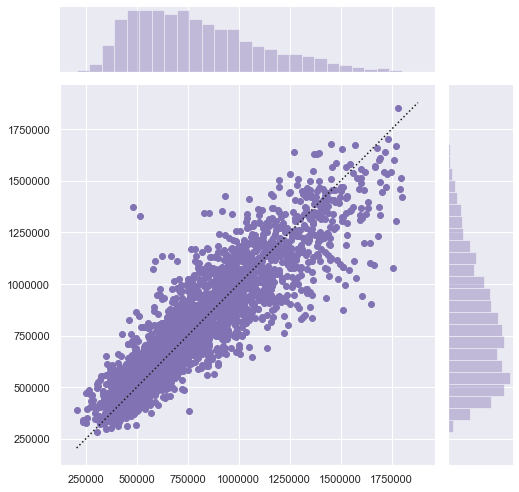

In [62]:
quick_train_eval(df, preds_best, target, method='poly2')
print('Best set of predictors is: ', preds_best)
print('These predictors have been sorted out: ', [i for i in preds if i not in preds_best])

# From those results above the best combination of predictors is stored inside: preds_best
# Now create the best model
X = df[preds_best]
y = df[target]
#X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

model = linear_model.LinearRegression()
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

model.fit(X_train,y_train)
y_hat = model.predict(X_test)

sns.set(style="darkgrid")

g = sns.jointplot(y_test, y_hat,
                  color="m", height=7)

x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')    

In [63]:
preds_best

['bedrooms',
 'sqft_living',
 'sqft_basement',
 'age',
 'condition_5',
 'floors_2.0',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'zip_sort']

In [64]:
# Price prediction for House Athens
# Athens: 6 bedrooms, 3 bathrooms, 2000 sqft_living, 0 sqft basement, 2021 built, 2021, condition 5, 2 floors, grade 9, zip: 35
# Berlin: 3 bedrooms, 1.5 bathrooms, 1200 sqft_living, 0 sqft basement, 2021 built, 2021, condition 5, 1.5 floors, grade 8, zip: 35

# Best set of predictors in this order is:
# ['bedrooms', 'sqft_living', 'sqft_basement'
#, 'age', 'condition_5', 'floors_2.0', 'grade_8'
#, 'grade_9', 'grade_10', 'grade_11', 'zip_sort']

X_pred = np.asanyarray([[6, 2000, 0, 2021, 1, 1, 0, 1, 0, 0, 35],
                       [3, 1200, 0, 2021, 1, 0, 1, 0, 0, 0, 35]])
X_pred = poly.fit_transform(X_pred)
X_pred = preprocessing.StandardScaler().fit(X_pred).transform(X_pred)

#y_hat = model.predict(X_pred)
print('Price house Athens:',round(y_hat[0][0]))
print('Price house Berlin:',round(y_hat[1][0]))  

Price house Athens: 373288.0
Price house Berlin: 1029429.0


Something seems to be wrong with extrapolating. The House Berlin should be cheaper than Athens. We will try my best with the linear model.

In [65]:
_preds = preds_best = preds
mape_best = 100

while True:
    
    _preds = [[f for f in preds_best if f != f2] for f2 in preds_best]
    _mape = []
    
    for predictors in _preds:
        _mape.append(quick_train_eval(df, predictors, target, method='poly1'))
        
    if mape_best > min(_mape):
        preds_best = _preds[_mape.index(min(_mape))]
        mape_best = min(_mape)
    else:
        break
    print(mape_best)

MAPE	 14.072780253590038
MAPE	 14.089886051032638
MAPE	 15.296245277733314
MAPE	 14.002395605643034
MAPE	 14.410685872835726
MAPE	 14.018231306831291
MAPE	 14.107291191674594
MAPE	 14.08071621668839
MAPE	 14.047747381337048
MAPE	 14.41057119800158
MAPE	 14.685111641978446
MAPE	 14.490888571742284
MAPE	 14.094168915190748
MAPE	 25.907431567767432
14.002395605643034
MAPE	 14.025584302708205
MAPE	 14.05097651093102
MAPE	 15.553944618538948
MAPE	 14.380796665703372
MAPE	 13.972822244485391
MAPE	 14.058217962218151
MAPE	 14.012883582758281
MAPE	 13.996820568757148
MAPE	 14.378851524331264
MAPE	 14.660786054805378
MAPE	 14.445322124021619
MAPE	 14.034981932451423
MAPE	 26.060964319189655
13.972822244485391
MAPE	 13.996888866630194
MAPE	 14.021545992636312
MAPE	 15.506317608302817
MAPE	 14.358589074274544
MAPE	 14.045241321903982
MAPE	 13.99334587905984
MAPE	 13.970271805808093
MAPE	 14.352952664221394
MAPE	 14.658941382960183
MAPE	 14.443898581316569
MAPE	 14.013155975692587
MAPE	 26.0495414

MAPE	 13.970271805808093
Best set of predictors is:  ['bedrooms', 'bathrooms', 'sqft_living', 'age', 'condition_5', 'floors_1.5', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'zip_sort']
These predictors have been sorted out:  ['sqft_basement', 'condition_4', 'floors_2.0']


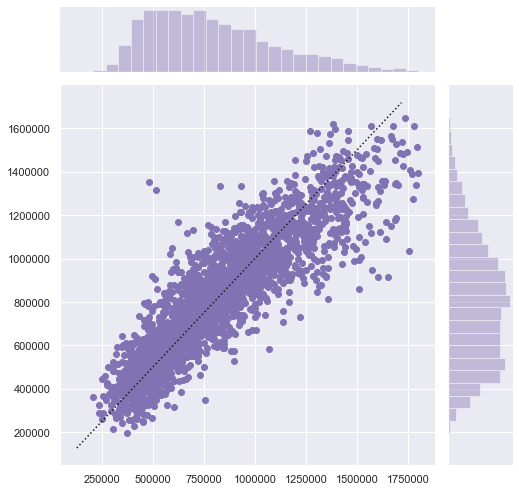

In [66]:
quick_train_eval(df, preds_best, target, method='poly1')
print('Best set of predictors is: ', preds_best)
print('These predictors have been sorted out: ', [i for i in preds if i not in preds_best])

# From those results above the best combination of predictors is stored inside: preds_best
# Now create the best model
X = df[preds_best]
y = df[target]
#X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

model = linear_model.LinearRegression()
poly = PolynomialFeatures(degree=1)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

model.fit(X_train,y_train)
y_hat = model.predict(X_test)

sns.set(style="darkgrid")

g = sns.jointplot(y_test, y_hat,
                  color="m", height=7)

x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')

In [67]:
# Price prediction for House Athens
# Athens: 6 bedrooms, 3 bathrooms, 2000 sqft_living, 2021 built, 2021, condition 5, 2 floors, grade 9, zip: 35
# Berlin: 3 bedrooms, 1.5 bathrooms, 1200 sqft_living, 2021 built, 2021, condition 5, 1.5 floors, grade 8, zip: 35

# Best set of predictors in this order is:
# ['bedrooms', 'bathrooms', 'sqft_living', 'age'
#, 'condition_5', 'floors_1.5', 'grade_8'
#, 'grade_9', 'grade_10', 'grade_11', 'zip_sort']

X_pred = np.asanyarray([[6, 3, 2000, 2021, 1, 0, 0, 1, 0, 0, 35],
                       [3, 1.5, 1200, 2021, 1, 1, 1, 0, 0, 0, 35]])
X_pred = poly.fit_transform(X_pred)
#X_pred = preprocessing.StandardScaler().fit(X_pred).transform(X_pred)

y_hat = model.predict(X_pred)
print('Price house Athens:',round(y_hat[0][0]))
print('Price house Berlin:',round(y_hat[1][0]))

Price house Athens: 948027.0
Price house Berlin: 726564.0


This seems to be way more plausible.

## Data Visualization

Communicate the findings with key stakeholder using plots and interactive visualizations

We will create an interactive local map with both the mean absolute price and the mean relative price upon toggleable layers.

In [76]:
# create spatial raster
# group in a spatial raster

for feat in ['long', 'lat']:
    df[feat+'_bin']=pd.cut(df[feat],bins=70)
    
df_rastered = df.groupby(by=['long_bin', 'lat_bin']).mean().dropna()
df_rastered.head()

price  bedrooms  bathrooms  \
long_bin            lat_bin                                                
(-122.51, -122.492] (47.342, 47.351]  363750.000000  3.000000   1.750000   
                    (47.36, 47.369]   310000.000000  3.000000   1.750000   
                    (47.387, 47.396]  319000.000000  3.000000   1.750000   
                    (47.44, 47.449]   423833.333333  2.666667   1.666667   
                    (47.449, 47.458]  437000.000000  5.000000   2.000000   

                                      sqft_living       sqft_lot   sqft_above  \
long_bin            lat_bin                                                     
(-122.51, -122.492] (47.342, 47.351]  1726.000000  197326.000000  1726.000000   
                    (47.36, 47.369]   1560.000000   82328.000000  1560.000000   
                    (47.387, 47.396]  1640.000000   53400.000000  1640.000000   
                    (47.44, 47.449]   1846.666667   67995.666667  1413.333333   
                    (47.449, 47.458]  2120.000000  137565.000000  2120.000000   

                                      sqft_basement     yr_built  \
long_bin            lat_bin                                        
(-122.51, -122.492] (47.342, 47.351]       0.000000  1982.000000   
                    (47.36, 47.369]        0.000000  1974.000000   
                    (47.387, 47.396]       0.000000  1966.000000   
                    (47.44, 47.449]      433.333333  1960.666667   
                    (47.449, 47.458]       0.000000  1913.000000   

                                      yr_renovated  zipcode  ...          age  \
long_bin            lat_bin                                  ...                
(-122.51, -122.492] (47.342, 47.351]           0.0  98070.0  ...  1982.000000   
                    (47.36, 47.369]            0.0  98070.0  ...  1974.000000   
                    (47.387, 47.396]           0.0  98070.0  ...  1966.000000   
                    (47.44, 47.449]            0.0  98070.0  ...  1960.666667   
                    (47.449, 47.458]           0.0  98070.0  ...  1913.000000   

                                      condition_4  condition_5  floors_1.5  \
long_bin            lat_bin                                                  
(-122.51, -122.492] (47.342, 47.351]          1.0          0.0         0.0   
                    (47.36, 47.369]           0.0          0.0         0.0   
                    (47.387, 47.396]          1.0          0.0         0.0   
                    (47.44, 47.449]           1.0          0.0         0.0   
                    (47.449, 47.458]          0.0          0.0         1.0   

                                      floors_2.0  grade_8  grade_9  grade_10  \
long_bin            lat_bin                                                    
(-122.51, -122.492] (47.342, 47.351]    1.000000      0.0      0.0       0.0   
                    (47.36, 47.369]     0.000000      0.0      0.0       0.0   
                    (47.387, 47.396]    0.000000      0.0      0.0       0.0   
                    (47.44, 47.449]     0.333333      0.0      0.0       0.0   
                    (47.449, 47.458]    0.000000      0.0      0.0       0.0   

                                      grade_11  zip_sort  
long_bin            lat_bin                               
(-122.51, -122.492] (47.342, 47.351]       0.0      31.0  
                    (47.36, 47.369]        0.0      31.0  
                    (47.387, 47.396]       0.0      31.0  
                    (47.44, 47.449]        0.0      31.0  
                    (47.449, 47.458]       0.0      31.0  

[5 rows x 26 columns]

In [69]:
# create a colormap for absolute prices
linear_price_adj = cm.LinearColormap(
    ['blue', 'red'],
    vmin=32e4, vmax=1e6
)
linear_price_adj

In [70]:
# create a colormap for relative prices
linear_spec_price = cm.LinearColormap(
    ['blue', 'red'],
    vmin=85, vmax=500
)
linear_spec_price

In [77]:
# define a function to draw a basemap easily

def generateBaseMap(default_location=[47.5112, -121.965], default_zoom_start=10):
    base_map = folium.Map(location=default_location
                          , control_scale=True
                          , zoom_start=default_zoom_start
                          , text_color = 'white'
                          #, tiles='Cartodb dark_matter'
                          , tiles='Stamen Toner'
                         )
    return base_map

basemap = generateBaseMap()

kw = {
    'radius': .4,
    'fill': True,
    #'weight': 1,
    'fill_opacity': 1
}

In [78]:
# add additional Layer layer_mp:mean price
layer_mp = folium.FeatureGroup('Mean price')
basemap.add_child(layer_mp)

# add additional Layer layer_sp:specific price
layer_sp = folium.FeatureGroup('Specific price')
basemap.add_child(layer_sp)

# add the colorbar
linear_price_adj.caption = 'Mean price of houses in the area in $'
linear_price_adj.text_color = 'white'
#linear.add_to(basemap)

# Price Markers
df_rastered.apply(lambda row:
                  layer_mp.add_child(
                      folium.CircleMarker(
                          location=[row["lat"], row["long"]]
                          , fill_color=linear_price_adj(row['price_adj'])
                          , color=linear_price_adj(row['price_adj'])
                          , **kw)), axis=1);

In [79]:
# add the colorbar
linear_spec_price.caption = 'Specific price of houses in the area in $/sqft'
linear_spec_price.text_color = 'white'
#linear.add_to(basemap)

# Price Markers
df_rastered.apply(lambda row:
                  layer_sp.add_child(
                      folium.CircleMarker(
                          location=[row["lat"], row["long"]]
                          , fill_color=linear_spec_price(row['spec_price'])
                          , color=linear_spec_price(row['spec_price'])
                          , **kw)), axis=1);

In [80]:
folium.LayerControl().add_to(basemap)
basemap

## Conclusions

+ Including the sorted-zip feature gives us a plus of more than 10 percentage points concerning MAPE. This is a good feature if we have all zipcodes represented in the training dataset. The transformation for the testset needs to include a default representative zipcode.
+ Dropping some features increased accuracy a little bit
+ The linear model performs better than the polynomial model in terms of extrapolation the portfolio.

## Future Work

This is a first impression of what could be done with the business case. In the following We will describe some ideas i hadn't the time for or that would some additional information.

### More location features

The data is quite dependent on location. The trick with the zipcodes gave us a plus of 10% points on MAPE. Further information about lot pricing might increase prediction accuracy. Also then we might be able to devide prices into building site prices and housing prices which would benefit further in depth analysis for the housing market.

Additionally a feature like the distance to water or the city centre would increase accuracy even further.

### Tweaking the Hyperparameters

As we germans say, the trick in finding the best feature-set was done with "woodhammer". There is definitely optimization potential in finding the best set of parameters and varying the model hyperparameters.

### Deriving Business Recommendations about a favourable Housing portfolio

For the prefabricator there might be potential to tweak the own portfolio for the local market. Wet would be interesting to see which houses are being sold for higher prices relative to their configuration. For that business inside information like specific construction-costs would be needed.

### Inspecting polynomial model

The fact that the polynomial model performed so poorly raises my attention. I would like to inspect this further and find out why.